Notebook purpose

- Explore whether I can see fresh-start effect in the data

Fidinds and decision:

- As a proof-of-concept, I just focus on purchases at major fast-food restaurants.

- MDB data is not ideal for this because dates are off, especially around the weekend, because banks post txns with a delay. This can be avoided by focusing on users who use online banks, but that reduces the sample considerably (and might not give us the full financial picture of a user's spending, though the accounts of online banks tend to be used for everyday spending, which is what I care about here).

- Unsurprisingly, the results with MDB data are thus not conclusive.

- I could use Fable data for this. But for now I'll hold off because I don't want to spend time putting together a Fable dataset that I might not use in the end. But this is something I could do if I want to come back to this.


In [1]:
import os
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

## MDB data

### Load data

In [2]:
dfs, dfl = hd.read_samples(["777", "XX7"])
hd.inspect(dfl)

Time for read_sample    : 2.54 seconds
Time for read_sample    : 4.88 minutes
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


## Analysis

In [154]:
def make_data(df, start=None, end=None):
    df = df.copy()

    # use online banks only, since for other banks, date of txns doesn't
    # equal date when purchase actually happened, esp. around weekends
    online_banks = ["starling bank", "revolut", "monzo"]
    df = df[df.account_provider.isin(online_banks)]

    fast_food_merchs = [
        "mcdonalds",
        "kfc",
        "burger king",
        "five guys",
    ]
    mask = df.merchant.isin(fast_food_merchs)
    df["fast_food"] = df.amount.where(mask, np.nan)
    df = (
        df.groupby("date")
        .fast_food.agg([("txns", "count"), ("spend", "sum")])
        .reset_index()
    )

    df["moy"] = df.date.dt.month
    df["dom"] = df.date.dt.day
    df["dow"] = df.date.dt.dayofweek + 1
    return df.set_index("date").loc[start:end]


df = make_data(dfl, start=None, end="2019")
hd.inspect(df)

(931, 5)


,txns,spend,moy,dom,dow
date,,,,,
2017-05-20,0,0.0,5,20,6
2017-05-27,0,0.0,5,27,6


In [155]:
from stargazer.stargazer import Stargazer

results = []
for y in ["txns", "spend"]:
    results.append(smf.ols(f"{y} ~ 1 + dom", data=df).fit())
    results.append(smf.ols(f"{y} ~ 1 + dow", data=df).fit())
    results.append(smf.ols(f"{y} ~ 1 + moy", data=df).fit())
    results.append(smf.ols(f"{y} ~ 1 + dow + dom + moy", data=df).fit())
Stargazer(results)

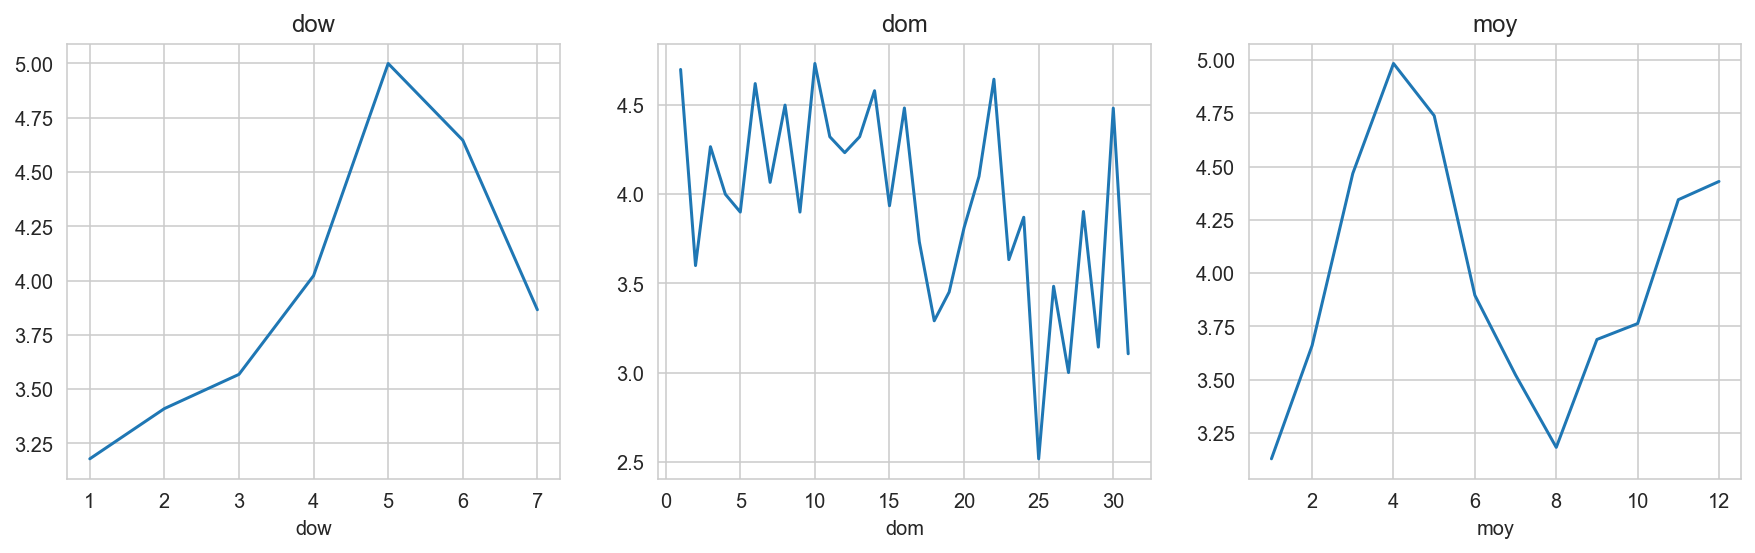

In [156]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
variables = ["dow", "dom", "moy"]
for idx, v in enumerate(variables):
    df.groupby(v).txns.mean().plot(ax=ax[idx])
    ax[idx].set_title(v)

### Discussion

- While aggregate regression results for dow and moy are consistent with the idea of a fresh start, the plots definitely aren't: dow suggests that people buy fast food on Fri and Sat (not surprising at all), moy suggests that they buy less fast food in summer.

## Fable data

In [18]:
fs.ls("3di-data-fable/raw/History/Core/2019")[:3]

['3di-data-fable/raw/History/Core/2019/ClientOutputMain_Core_2018_12_31_2019_01_06.csv',
 '3di-data-fable/raw/History/Core/2019/ClientOutputMain_Core_2019_01_07_2019_01_13.csv',
 '3di-data-fable/raw/History/Core/2019/ClientOutputMain_Core_2019_01_14_2019_01_20.csv']

In [3]:
fp = "s3://3di-data-fable/raw/History/Core/2019/ClientOutputMain_Core_2018_12_31_2019_01_06.csv"
cols = ["TxnDate", "Description", "UserCountry", "SpendOut"]
df = ha.read_csv(fp, usecols=cols)

In [11]:
def clean_fable(df, start=None, end=None):
    df = df.copy()
    df = df[df.UserCountry.eq("UK")].drop("UserCountry", axis=1)
    df["date"] = pd.to_datetime(df.TxnDate)

    fast_food_merchs = "mcdonalds|kfc|burger king|five guys"
    mask = df.Description.str.contains(fast_food_merchs)
    df["fast_food"] = df.SpendOut.where(mask, np.nan)
    df = (
        df.groupby("date")
        .fast_food.agg([("txns", "count"), ("spend", "sum")])
        .reset_index()
    )

    df["moy"] = df.date.dt.month
    df["dom"] = df.date.dt.day
    df["dow"] = df.date.dt.dayofweek + 1
    return df.set_index("date").loc[start:end]


data = clean_fable(df)
hd.inspect(data)

(95, 5)


,txns,spend,moy,dom,dow
date,,,,,
2017-10-24,0,0.0,10,24,2
2018-01-01,0,0.0,1,1,1


In [12]:
data = data
results = []
for y in ["txns", "spend"]:
    results.append(smf.ols(f"{y} ~ 1 + dom", data=data).fit())
    results.append(smf.ols(f"{y} ~ 1 + dow", data=data).fit())
    results.append(smf.ols(f"{y} ~ 1 + moy", data=data).fit())
    results.append(smf.ols(f"{y} ~ 1 + dow + dom + moy", data=data).fit())
Stargazer(results)